# Bluesky SAXS measurements
First attempts at using Bluesky to comduct an experimental campaign
Bluesky deployment by Lee Yang, in presence on Xiaoya Chong

awoudjyla@lbl.gov, llyang@lbl.gov; November 2023

In [1]:
import epics
import numpy as np

In [2]:
'13PIL1:cam1:Acquire'
'13SIM1:cam1:PortName_RBV'
str = epics.caget('13PIL:cam1:PortName_RBV')


cannot connect to 13PIL:cam1:PortName_RBV


In [3]:
from bluesky import RunEngine
RE = RunEngine({})

from databroker import Broker
db = Broker.named('temp')

# Insert all metadata/data captured into db.
RE.subscribe(db.insert)

/home/bl531/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


0

In [4]:
import bluesky

### Declaring PV ad IOCs

In [7]:
pv_m101_pitch_mm  = 'bl531_esp300:m101_pitch_mm'
pv_m101_bend_um   = 'bl531_esp300:m101_bend_um'
pv_mono_height_mm = 'bl531_xps1:mono_height_mm'
pv_mono_angle_deg = 'bl531_xps1:mono_angle_deg'

#DMC02:E.CNEN
pv_pilatus = '13PIL1:cam1:Acquire'
pv_pilatus = '13PIL1:'

### Setting up ophyd objects

In [26]:
from ophyd import EpicsMotor
import ophyd
ophyd.set_cl('caproto')

#that does not work
#det = ophyd.EpicsMotor('BL531:PS:POS_0', name='picoscale') 
#det.read()

#bl531_current = ophyd.EpicsSignal('bl201-beamstop:current', name='picoammeter')
# do not do a read in the same cell! too fast

#this works
#bl531_current.wait_for_connection(timeout=2.0)
#bl531_current.read()

#
mono_angle_deg = EpicsMotor(pv_mono_angle_deg, name='Mono theta deg')
mono_angle_deg.wait_for_connection(timeout=2.0)
mono_angle_deg.read()

OrderedDict([('Mono theta deg',
              {'value': 30.0, 'timestamp': 1700510248.620644}),
             ('Mono theta deg_user_setpoint',
              {'value': 30.0, 'timestamp': 1700510266.9273663})])

In [8]:
from ophyd.areadetector.detectors import PilatusDetector
det = PilatusDetector(pv_pilatus,name='det')

In [15]:
#det.missing_plugins()
det.cam.acquire

EpicsSignalWithRBV(read_pv='13PIL1:cam1:Acquire_RBV', name='det_cam_acquire', parent='det_cam', timestamp=1700506524.0266507, auto_monitor=False, string=False, write_pv='13PIL1:cam1:Acquire', limits=False, put_complete=False)

In [16]:
from bluesky.plans import count
#dets = [det1, det2]   # a list of any number of detectors

dets = [det]   # a list of any number of detectors
motors = mono_angle_deg

RE(count(dets))

('ffb89dfa-b7e2-4def-8b02-1d422b49c4c4',)

In [20]:
from bluesky.plans import scan
RE(scan(dets, motors, 29, 30, 11))



Transient Scan ID: 3     Time: 2023-11-20 11:00:51
Persistent Unique Scan ID: 'a0cdecb5-b608-4161-a732-25e4e9af0f1a'
New stream: 'primary'
+-----------+------------+----------------+
|   seq_num |       time | Mono theta deg |
+-----------+------------+----------------+
|         1 | 11:00:53.2 |        29.0000 |
|         2 | 11:00:53.9 |        29.1000 |
|         3 | 11:00:54.6 |        29.2000 |
|         4 | 11:00:55.2 |        29.3000 |
|         5 | 11:00:55.9 |        29.4000 |
|         6 | 11:00:56.6 |        29.5000 |
|         7 | 11:00:57.3 |        29.6000 |
|         8 | 11:00:58.0 |        29.7000 |
|         9 | 11:00:58.6 |        29.8000 |
|        10 | 11:00:59.3 |        29.9000 |
|        11 | 11:01:00.0 |        30.0000 |
+-----------+------------+----------------+
generator scan ['a0cdecb5'] (scan num: 3)





('a0cdecb5-b608-4161-a732-25e4e9af0f1a',)

In [21]:
header = db[-1]
header.table()

,time,Mono theta deg,Mono theta deg_user_setpoint
seq_num,,,
1,2023-11-20 19:00:53.263742447,29.0,29.0
2,2023-11-20 19:00:53.945857048,29.1,29.1
3,2023-11-20 19:00:54.621348381,29.2,29.2
4,2023-11-20 19:00:55.290686131,29.3,29.3
5,2023-11-20 19:00:55.974861860,29.4,29.4
6,2023-11-20 19:00:56.647002220,29.5,29.5
7,2023-11-20 19:00:57.332709074,29.6,29.6
8,2023-11-20 19:00:58.011858702,29.7,29.7
9,2023-11-20 19:00:58.695772648,29.8,29.8


In [ ]:
# some issues here -- not critical
from bluesky.callbacks.best_effort import BestEffortCallback
bec = BestEffortCallback()

# Send all metadata/data captured to the BestEffortCallback.
RE.subscribe(bec)

# Make plots update live while scans run.
from bluesky.utils import install_kicker
install_kicker()

In [25]:
table = db[-1].table(fill=True)

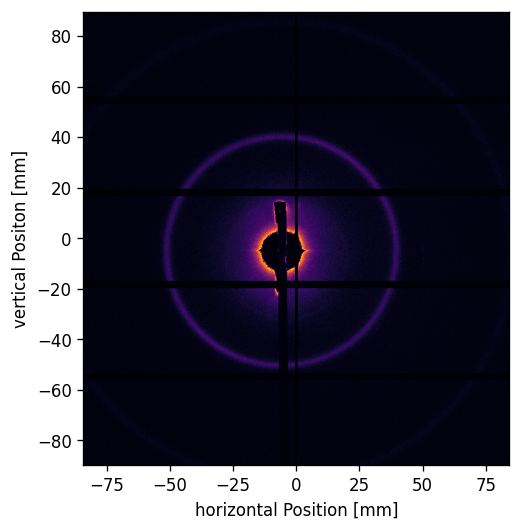

In [28]:
#read a image
import numpy as np
from PIL import Image

filepath = '/mnt/pilatus/sample_20231120_166.tif'

# read the image
im_tiff = Image.open(filepath)
# make the image a numpy array so that we can process it
im_np = np.squeeze(np.array(im_tiff.getdata()).reshape(im_tiff.size[1], im_tiff.size[0], 1))

# dealing with dyanmic range
im_np[np.where(im_np>100.0)] =0

import matplotlib.pyplot as plt
dx_m = 172e-6
Nx_px = 981
Ny_px = 1043
Dx_m = Nx_px*dx_m
Dy_m = Ny_px*dx_m

fig=plt.figure(figsize=(5, 5), dpi= 120, facecolor='w', edgecolor='k')
extent = (-Dx_m/2 * 1e3, +Dx_m/2 * 1e3, -Dy_m/2 * 1e3, +Dy_m/2 * 1e3)
# extent = (-Nx_px/2, +Nx_px/2, -Ny_px/2, +Ny_px/2) #pixels

plt.imshow(im_np, extent=extent, cmap = 'inferno')
plt.xlabel('horizontal Position [mm]')
plt.ylabel('vertical Positon [mm]')
plt.show()